In [154]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import scipy.signal as sciSig

# Load Image and Display


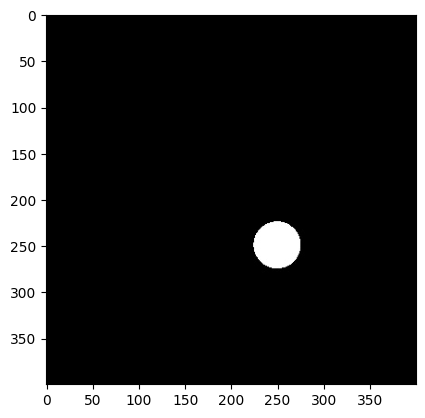

In [143]:
def load_image(path):
    return np.array(Image.open(path).convert('L'))

image_array = load_image('img/Kropka.jpg')

plt.imshow(image_array, cmap='gray')
plt.show()

# Radon Transform

- Bresenham's algorithm

In [144]:
def radon_transform(image, length, num_detectors, alpha):
    
    height, width_img = image.shape
    center = [width_img // 2, height // 2]  # Image's center
    radius = min(center)
    
    sinogram = []
    ray_lines = []
    
    for angle in range(0, 360, alpha):  # zebranie probek promieni over angle on full circle
        sinogram.append([])
        ray_lines.append([])
        
        # stożkowy model
        for detector_idx in range(num_detectors):  # loop over detectors
            emitter_x = radius * np.cos(np.radians(angle))
            emitter_y = radius * np.sin(np.radians(angle))
            detector_x = radius * np.cos(np.radians(angle + 180 - (length / 2) + detector_idx * (length / (num_detectors - 1))))
            detector_y = radius * np.sin(np.radians(angle + 180 - (length / 2) + detector_idx * (length / (num_detectors - 1))))
            
            emitter_x = int(emitter_x) + center[0]
            emitter_y = int(emitter_y) + center[1]
            detector_x = int(detector_x) + center[0]
            detector_y = int(detector_y) + center[1]
            
            ray_line = bresenham(emitter_x, emitter_y, detector_x, detector_y)
            pixel_intensity = calculate_ray_intensity(image, ray_line)
            
            sinogram[-1].append(pixel_intensity)
            ray_lines[-1].append([emitter_x, emitter_y, detector_x, detector_y])
    
    return sinogram, ray_lines


def bresenham(x0, y0, x1, y1):
    line = []
    kx = 1 if x0 <= x1 else -1
    ky = 1 if y0 <= y1 else -1

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    x = x0
    y = y0
    line.append([x, y])
    if dx >= dy:
        e = dx / 2
        for i in range(0, int(dx)):
            x = x + kx
            e = e - dy
            if e < 0:
                y = y + ky
                e = e + dx
            line.append([x, y])
    else:
        e = dy / 2
        for i in range(0, int(dy)):
            y = y + ky
            e = e - dx
            if e < 0:
                x = x + kx
                e = e + dy
            line.append([x, y])
    return line


def calculate_ray_intensity(image, ray_line):

    raw_intensity = 0
    pixel_count = 0
    
    for x, y in ray_line:
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            raw_intensity += image[y, x]
            pixel_count += 1
    
    assert pixel_count != 0
    normalized_intensity = raw_intensity / pixel_count
    
    return normalized_intensity

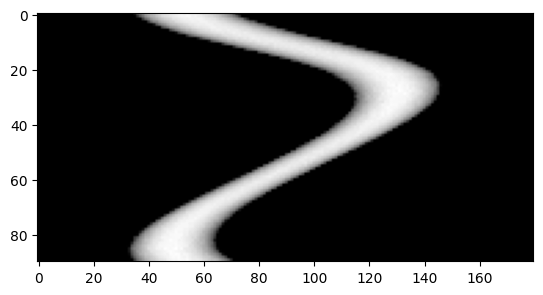

In [145]:
length=180
detector_amount=180
alpha=4

sinogram, lines = radon_transform(image_array, length, detector_amount, alpha)
plt.imshow(sinogram, cmap='gray')

plt.show()

# Filter sinogram

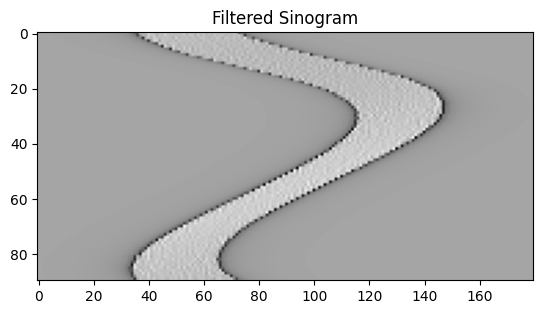

In [161]:
def filter_sinogram(sinogram):
    
    sinogram_shape = np.shape(sinogram)
    num_projections = sinogram_shape[0]
    num_detectors = sinogram_shape[1]
    filtered = np.zeros_like(sinogram)
    mask_size = math.floor(num_detectors / 2)
    mask = np.zeros(mask_size)
    center = math.floor(mask_size / 2)

    for i in range(0, mask_size, 1):
        k = i - center
        if k % 2 != 0:
            mask[i] = (-4 / np.pi ** 2) / k ** 2
    mask[center] = 1

    for proj_idx in range(num_projections):
        filtered[proj_idx] = sciSig.fftconvolve(sinogram[proj_idx], mask, mode='same')

    return filtered


filtered_sinogram = filter_sinogram(sinogram)

plt.figure()
plt.imshow(filtered_sinogram, cmap='gray')
plt.title('Filtered Sinogram')
plt.show()

# Get output image from filtered sinogram